# Define shapes of aerosol particles as inputs for ADDA scattering model 
## Author: Zhibo Zhang (zhibo.zhang@umbc.edu)
## First Developed in 2021


In [80]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
if importlib.util.find_spec("pyny3d") is None:
  !pip install pyny3d
import pyny3d.geoms as pyny
import plotly.graph_objects as go

## define the basic blocks for building a polyhedron

In [81]:
class plane(object):
  def __init__(self, norm_theta, norm_phi, point_on_plane):
    norm_vector = np.array([np.sin(norm_theta)*np.cos(norm_phi),
                            np.sin(norm_theta)*np.sin(norm_phi),
                            np.cos(norm_theta)])
    self.N  = norm_vector
    self.P0 = point_on_plane
    NdotP0 = np.sum(self.N*self.P0)
    self.standard_para = np.array([self.N[0],self.N[1],self.N[2],-NdotP0])

class intersect(plane):
  def __init__(self,plane_list):
    from numpy.linalg import matrix_rank,solve 
    M = np.zeros([3,3])
    MA = np.zeros([3,4])
    B = np.zeros(3)
    for i in range(3):
      M[i,:]=plane_list[i].standard_para[0:-1]
      MA[i,:]=plane_list[i].standard_para
      B[i] = plane_list[i].standard_para[-1]
    r1 = matrix_rank(M)
    rp = matrix_rank(MA)
    # print('rank',r1,rp)
    # print(M)
    if (r1==3) and (rp==3):
      self.J=solve(M,-B)
    else:
      
      self.J=None
    




## define some basic polyhedra such as cube and irregular hexadron

In [82]:
class cube():
  def __init__(self,):
    self.faces = []
    N0_theta,N0_phi = np.pi/2.0, -np.pi/2.0
    P0=np.array([0.5,0,0.5])
    self.faces.append(plane(N0_theta, N0_phi,P0))
    print('face0',self.faces[-1].N)

    N1_theta,N1_phi = np.pi/2.0, 0.0
    P1=np.array([1.0,0.5,0.5])
    self.faces.append(plane(N1_theta, N1_phi,P1))
    print('face1',self.faces[-1].N)

    N2_theta,N2_phi = np.pi/2.0, np.pi/2.0
    P2=np.array([0.5,1.0,0.5])
    self.faces.append(plane(N2_theta, N2_phi,P2))
    print('face2',self.faces[-1].N)

    N3_theta,N3_phi = np.pi/2.0, np.pi
    P3=np.array([0.0,0.5,0.5])
    self.faces.append(plane(N3_theta, N3_phi,P3))
    print('face3',self.faces[-1].N)

    N4_theta,N4_phi = np.pi, 0.0
    P4=np.array([0.5,0.5,0.0])
    self.faces.append(plane(N4_theta, N4_phi,P4))
    print('face4',self.faces[-1].N)

    N5_theta,N5_phi = 0.0, 0.0
    P5=np.array([0.5,0.5,1.0])
    self.faces.append(plane(N5_theta, N5_phi,P5))
    print('face5',self.faces[-1].N)

    self.vertices = []
    P=intersect([self.faces[0],self.faces[3],self.faces[4]])
    self.vertices.append(P)

    P=intersect([self.faces[0],self.faces[3],self.faces[5]])
    self.vertices.append(P)

    P=intersect([self.faces[0],self.faces[1],self.faces[4]])
    self.vertices.append(P)

    P=intersect([self.faces[0],self.faces[1],self.faces[5]])
    self.vertices.append(P)

    P=intersect([self.faces[2],self.faces[3],self.faces[4]])
    self.vertices.append(P)

    P=intersect([self.faces[2],self.faces[3],self.faces[5]])
    self.vertices.append(P)

    P=intersect([self.faces[2],self.faces[1],self.faces[4]])
    self.vertices.append(P)

    P=intersect([self.faces[2],self.faces[1],self.faces[5]])
    self.vertices.append(P)
class irragular_hexahedron():
  def __init__(self,x,yx_ratio=1,zx_ratio=1,
               theta_perturb_max=0.0,phi_perturb_max=0.0,
               write_obj_file=False):
    self.x=x            # x dimention length
    self.y=x*yx_ratio   # y dimension length
    self.z=x*zx_ratio   # z dimension length
    self.nv = 8         # numer of vertices
    self.nf = 6         # number of faces
    # the normal direction of each faces is determined by two angles in 
    # spherical coordinate (theta, phi)

    # theta angles of the normal direction of each face
    fn_theta = np.array([np.pi,np.pi/2.0,np.pi/2.0,
                         np.pi/2.0,np.pi/2.0,0.0]) 
    fn_theta += np.random.randn(self.nf)*theta_perturb_max
    # phi angles of the normal direction of each face
    fn_phi   = np.array([0.0,np.pi,np.pi/2.0,
                         0.0,-np.pi/2.0,0.0,])
    fn_phi += np.random.randn(self.nf)*phi_perturb_max

    # coordinate of the center point of each face
    P0 = np.array([[self.x/2.0,self.y/2.0,0.0], # bottom
                  [0.0,self.y/2.0,self.z/2.0],  # Left
                  [self.x/2.0,self.y,self.z/2.0], # back
                  [self.x,self.y/2.0,self.z/2.0],  # right
                  [self.x/2.0,0.0,self.z/2.0],    # front
                  [self.x/2.0,self.y/2.0,self.z]]) # top
    
    self.faces = []
    for i in range(self.nf):
      self.faces.append(plane(fn_theta[i], 
                              fn_phi[i],
                              P0[i,:]))
    
    
    self.face_combination=np.array([[0,1,4],
                               [1,4,5],
                               [0,1,2],
                               [1,2,5],
                               [0,3,4],
                               [3,4,5],
                               [0,2,3],
                               [2,3,5]])
    
    self.vertices = []
    for j in range(self.nv):
      P=intersect([self.faces[self.face_combination[j,k]] for k in range(3)])
      self.vertices.append(P)
    
    self.vertex_combination = np.array([[0,2,6,4],
                                        [0,1,3,2],
                                        [2,3,7,6],
                                        [4,5,7,6],
                                        [0,1,5,4],
                                        [1,3,7,5]])
    face_list = []
    for f in range(self.nf):
      face=np.array([self.vertices[self.vertex_combination[f,i]].J 
                     for i in range(4)])
      face_list.append(pyny.Polygon(face))
    self.final_shape=pyny.Polyhedron(face_list)
    self.final_shape.plot(color='t')
    domain_vortex = self.final_shape.get_domain()
    print(domain_vortex)
    vertex_write_order=np.array([[1,  7,  5],
                                [1,  3,  7],
                                [1,  4,  3],
                                [1,  2,  4],
                                [3,  8,  7],
                                [3,  4,  8],
                                [5,  7,  8],
                                [5,  8,  6], 
                                [1,  5,  6],
                                [1,  6,  2],
                                [2,  6,  8],
                                [2,  8,  4]])

    nl,_=vertex_write_order.shape
    if write_obj_file:
      with open('asym_box.obj','w') as fout:
        fout.write('# asymmetric box object\n')
        for i in range(self.nv):
          fout.write('v {0:7.3f} {1:7.3f} {2:7.3f} \n'.format(self.vertices[i].J[0],
                                                              self.vertices[i].J[1],
                                                              self.vertices[i].J[2]))
        for f in range(nl):
          print(f,vertex_write_order[f,:])
          fout.write('f {0:2d} {1:2d} {2:2d} \n'.format(vertex_write_order[f,0],
                                                        vertex_write_order[f,1],
                                                        vertex_write_order[f,2]))
      
      

[[-0.21182834 -0.13835933 -0.09165692]
 [ 1.10397737  1.12314274  1.07811199]]
0 [1 7 5]
1 [1 3 7]
2 [1 4 3]
3 [1 2 4]
4 [3 8 7]
5 [3 4 8]
6 [5 7 8]
7 [5 8 6]
8 [1 5 6]
9 [1 6 2]
10 [2 6 8]
11 [2 8 4]


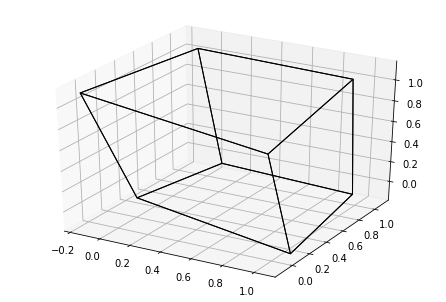

In [83]:
B=irragular_hexahedron(1.0,1.0,1.0,np.pi/20,np.pi/20.0,write_obj_file=True)
#B=asym_box2(1.0,write_obj_file=True)

## Build Irragular Hexahedron and write .geom file



In [89]:
class ADDA_irragular_hexahedron():
  
  def __init__(self,wavelength, dpl,x,yx_ratio=1,yz_ratio=1,
                              theta_perturb_max=0.0,phi_perturb_max=0.0,
                              write_geom_file=False,plotly_rendering=False):
    irr_hex = irragular_hexahedron(x,yx_ratio,yz_ratio,
                                theta_perturb_max,phi_perturb_max)
    
    r0,r1=irr_hex.final_shape.get_domain()
    dipole_d=wavelength/dpl
    dipole_r=dipole_d/2.0

    nx,ny,nz = (np.array([r1[i]-r0[i] for i in [0,1,2]])/dipole_d).astype(int)
    print('domain size',nx,ny,nz)
    inside = np.ones((nx, ny, nz), dtype=bool)
    x = np.zeros((nx, ny, nz))
    y = np.zeros((nx, ny, nz))
    z = np.zeros((nx, ny, nz))
    #index =  np.zeros((nx, ny, nz, 3), dtype=int)
    for ix in range(nx):
      for iy in range(ny):
        for iz in range(nz):
          # coordinate of a point in the domain
          x[ix,iy,iz] = r0[0] + ix*dipole_d + dipole_r
          y[ix,iy,iz] = r0[1] + iy*dipole_d + dipole_r
          z[ix,iy,iz] = r0[2] + iz*dipole_d + dipole_r
          r=np.array([x[ix,iy,iz],y[ix,iy,iz],z[ix,iy,iz]])
          for f in range(irr_hex.nf):
            P0mr=irr_hex.faces[f].P0 - r
            P0mr_dot_fn = np.sum(P0mr*irr_hex.faces[f].N)
            if P0mr_dot_fn < 0:
              inside[ix,iy,iz]=False
              break
    
    print('volume',np.sum(inside),inside.size)
    if write_geom_file:
      with open('irragular_hexahedron.geom','w') as fout:
        fout.write('#generated by Zhibo Zhang Python script\n')
        fout.write('#shape: irragular hexahedron \n')
        fout.write('#box size: {0:}x{1:}x{2:} \n'.format(nx,ny,nz))
        for ix in range(nx):
          for iy in range(ny):
            for iz in range(nz):
              if inside[ix,iy,iz]:
                fout.write('{0:} {1:} {2:}\n'.format(ix,iy,iz))

    if plotly_rendering:
      values = inside.astype(float)
      
      fig = go.Figure(data=go.Volume(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        value=values.flatten(),
        isomin=0.9,
        isomax=1.1,
        opacity=0.8, # needs to be small to see through all surfaces
        surface_count=17, # needs to be a large number for good volume rendering
        colorscale='Gray'
        ))
      fig.show()

    return
  

In [91]:
cb =ADDA_irragular_hexahedron(0.5, 20,1,1.0,2.0,np.pi/20,np.pi/20,\
                              write_geom_file=True,plotly_rendering=True)

Output hidden; open in https://colab.research.google.com to view.

[[-0.05686348 -0.13136042 -0.00717348]
 [ 1.03740882  1.33952548  2.05688093]]
domain size 43 58 82
volume 154144 204508


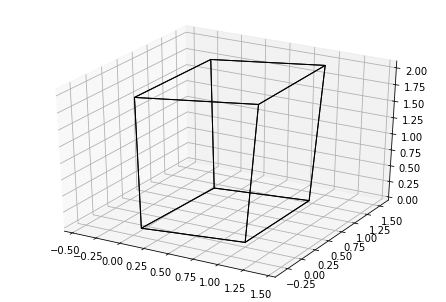

In [ ]:
irh =ADDA_irragular_hexahedron(0.5, 20,1,1.2,2.0,np.pi/20.0,np.pi/20.0,write_geom_file=True)

## Build Triaxial Ellipsoid

In [ ]:
class ADDA_triaxial_ellipsoid(object):
  def __init__(self,wavelength, dpl,x,
               yx_ratio=1.0,zx_ratio=1.0,
               write_geom_file=False,
               plotly_rendering = False):
    self.x=x
    self.y=x*yx_ratio
    self.z=x*zx_ratio
    a2=(self.x**2)/4.0
    b2=(self.y**2)/4.0
    c2=(self.z**2)/4.0
    dipole_d=wavelength/dpl
    dipole_r=dipole_d/2.0 
    nx = np.ceil(self.x/dipole_d).astype(int)
    ny = np.ceil(self.y/dipole_d).astype(int)
    nz = np.ceil(self.z/dipole_d).astype(int)
    print('domain size',nx,ny,nz)

    # center of the ellipsoid is at [0,0,0]
    inside = np.ones((nx, ny, nz), dtype=bool)
    xp = np.zeros([nx, ny, nz])
    yp = np.zeros([nx, ny, nz])
    zp = np.zeros([nx, ny, nz])
    for ix in range(nx):
      for iy in range(ny):
        for iz in range(nz):
          # coordinate of a point in the domain
          xp[ix,iy,iz] = -self.x/2.0 + ix*dipole_d + dipole_r
          yp[ix,iy,iz] = -self.y/2.0 + iy*dipole_d + dipole_r
          zp[ix,iy,iz] = -self.z/2.0 + iz*dipole_d + dipole_r
          d = np.sum(xp[ix,iy,iz]**2/a2+yp[ix,iy,iz]**2/b2+zp[ix,iy,iz]**2/c2)
          if d>1.0:
            inside[ix,iy,iz] = False

    print('volume',np.sum(inside),inside.size)
    self.volume = np.pi/6*self.x*self.y*self.z
    self.surf_area = np.pi*4.0*np.power(((self.x/2.0*self.y/2.0)**1.6/3.0+
                                        (self.x/2.0*self.z/2.0)**1.6/3.0+
                                        (self.y/2.0*self.z/2.0)**1.6/3.0),1/1.6) 
    if write_geom_file:
      with open('triaxial_ellipsoid.geom','w') as fout:
        fout.write('#generated by Zhibo Zhang Python script\n')
        fout.write('#shape: triaxial ellipsoid \n')
        fout.write('#box size: {0:}x{1:}x{2:} \n'.format(nx,ny,nz))
        for iz in range(nz):
          for iy in range(ny):
            for ix in range(nx):
              if inside[ix,iy,iz]:
                fout.write('{0:4d} {1:4d} {2:4d}\n'.format(ix,iy,iz))

    if plotly_rendering:
      # X, Y, Z = np.mgrid[-self.x/2:self.x/2:40j,
      #                    -self.y/2:self.y/2:40j,
      #                    -self.z/2:self.z/2:40j]
      
      values = inside.astype(float)
      print(values.min(),values.shape,xp.shape)
      

      fig = go.Figure(data=go.Volume(
        x=xp.flatten(),
        y=yp.flatten(),
        z=zp.flatten(),
        value=values.flatten(),
        isomin=0.9,
        isomax=1.1,
        opacity=0.8, # needs to be small to see through all surfaces
        surface_count=17, # needs to be a large number for good volume rendering
        ))
      fig.show()

  

In [ ]:
te=ADDA_triaxial_ellipsoid(0.55,30,0.666,1,3.0,False,True)

Output hidden; open in https://colab.research.google.com to view.

## Build Coated Triaxial Ellipsoid

In [ ]:
class ADDA_coated_ellipsoids(object):
  def __init__(self,wavelength, dpl,x1,x2,
               y1x1_ratio=1.0,z1x1_ratio=1.0,
               y2x2_ratio=1.0,z2x2_ratio=1.0,
               write_geom_file=False,
               plotly_rendering=False):
    
    dipole_d=wavelength/dpl
    dipole_r=dipole_d/2.0 

    # parameters of inner ellipsoid
    self.x1=x1
    self.y1=x1*y1x1_ratio
    self.z1=x1*z1x1_ratio
    asq1=(self.x1**2)/4.0 # square of a1 
    bsq1=(self.y1**2)/4.0 # square of b1 
    csq1=(self.z1**2)/4.0 # square of c1 
    # parameters of outer ellipsoid
    # the outer ellipsoid must be *larger* than inner ellipsoid
    self.x2=x2
    self.y2=x2*y2x2_ratio
    self.z2=x2*z2x2_ratio
    asq2=(self.x2**2)/4.0 # square of a2 
    bsq2=(self.y2**2)/4.0 # square of b2 
    csq2=(self.z2**2)/4.0 # square of c2
  
    # nx1 = np.ceil(self.x1/dipole_d).astype(int)
    # ny1 = np.ceil(self.y1/dipole_d).astype(int)
    # nz1 = np.ceil(self.z1/dipole_d).astype(int)
    nx = np.ceil(self.x2/dipole_d).astype(int)
    ny = np.ceil(self.y2/dipole_d).astype(int)
    nz = np.ceil(self.z2/dipole_d).astype(int)
    # nx,ny,nz = max(nx1,nx2),max(ny1,ny2),max(nz1,nz2)
    print('domain size',nx,ny,nz)
    # center of the ellipsoid is at [0,0,0]
    inside = np.zeros((nx, ny, nz), dtype=bool)
    nmat   = np.zeros((nx, ny, nz), dtype=int)
    xp = np.zeros([nx, ny, nz])
    yp = np.zeros([nx, ny, nz])
    zp = np.zeros([nx, ny, nz])

    for ix in range(nx):
      for iy in range(ny):
        for iz in range(nz):
          # coordinate of a point in the domain
          xp[ix,iy,iz] = -self.x2/2.0 + ix*dipole_d + dipole_r
          yp[ix,iy,iz] = -self.y2/2.0 + iy*dipole_d + dipole_r
          zp[ix,iy,iz] = -self.z2/2.0 + iz*dipole_d + dipole_r
          d1 = np.sum(xp[ix,iy,iz]**2/asq1+yp[ix,iy,iz]**2/bsq1+zp[ix,iy,iz]**2/csq1)
          d2 = np.sum(xp[ix,iy,iz]**2/asq2+yp[ix,iy,iz]**2/bsq2+zp[ix,iy,iz]**2/csq2)
          if (d2<=1) and (d1>1):
            nmat[ix,iy,iz] = 1
            inside[ix,iy,iz] = True
          elif d1<=1:
            nmat[ix,iy,iz] = 2
            inside[ix,iy,iz] = True

    print('volume',np.sum(inside),inside.size)
    self.volume = np.pi/6*self.x2*self.y2*self.z2
    self.surf_area = np.pi*4.0*np.power(((self.x2/2.0*self.y2/2.0)**1.6/3.0+
                                        (self.x2/2.0*self.z2/2.0)**1.6/3.0+
                                        (self.y2/2.0*self.z2/2.0)**1.6/3.0),1/1.6) 
    if write_geom_file:
      with open('coated_ellipsoid.geom','w') as fout:
        fout.write('#generated by Zhibo Zhang Python script\n')
        fout.write('#shape: coated ellipsoid \n')
        fout.write('#box size: {0:}x{1:}x{2:} \n'.format(nx,ny,nz))
        for iz in range(nz):
          for iy in range(ny):
            for ix in range(nx):
              if nmat[ix,iy,iz]>0:
                fout.write('{0:4d} {1:4d} {2:4d} {3:2d}\n'.format(ix,iy,iz,nmat[ix,iy,iz]))
    if plotly_rendering:
      # X, Y, Z = np.mgrid[-self.x/2:self.x/2:40j,
      #                    -self.y/2:self.y/2:40j,
      #                    -self.z/2:self.z/2:40j]
      
      values = nmat.astype(float)
      print(values.min(),values.shape,xp.shape)
      

      fig = go.Figure(data=go.Volume(
        x=xp.flatten(),
        y=yp.flatten(),
        z=zp.flatten(),
        value=values.flatten(),
        isomin=0.0,
        isomax=2.1,
        opacity=0.1, # needs to be small to see through all surfaces
        surface_count=17, # needs to be a large number for good volume rendering
        ))
      fig.show()


In [ ]:
ace = ADDA_coated_ellipsoids(0.5, 150,0.1,0.13,\
                             y1x1_ratio=1.0,z1x1_ratio=2.0,\
                             y2x2_ratio=1.0,z2x2_ratio=2.0,write_geom_file=True,
                             plotly_rendering=True)

Output hidden; open in https://colab.research.google.com to view.

## Build Coated Spheres

In [ ]:
class ADDA_coated_sphere(object):
  def __init__(self,wavelength, dpl,d,
               din_to_d=0.5,
               write_geom_file=False):
    self.d=d
    self.din=d*din_to_d
    print(self.d,self.din)
    dipole_d=wavelength/dpl
    dipole_r=dipole_d/2.0 
    nx = ny = nz = np.ceil(self.d/dipole_d).astype(int)
    print('domain size',nx,ny,nz)
    nmat = np.zeros((nx, ny, nz),dtype=int)
    for ix in range(nx):
      for iy in range(ny):
        for iz in range(nz):
          # coordinate of a point in the domain
          xp = -self.d/2.0 + ix*dipole_d + dipole_r
          yp = -self.d/2.0 + iy*dipole_d + dipole_r
          zp = -self.d/2.0 + iz*dipole_d + dipole_r
          d = np.sqrt(np.sum(xp**2+yp**2+zp**2))
          if (d<self.d/2.0) and (d>=self.din/2.0):
            nmat[ix,iy,iz] = 1
          elif d<self.din/2.0:
            nmat[ix,iy,iz] = 2

    if write_geom_file:
      with open('coated_sphere.geom','w') as fout:
        fout.write('#generated by Zhibo Zhang Python script\n')
        fout.write('#shape: coated sphere \n')
        fout.write('#box size: {0:}x{1:}x{2:} \n'.format(nx,ny,nz))
        fout.write('Nmat=2 \n')
        for iz in range(nz):
          for iy in range(ny):
            for ix in range(nx):
              if nmat[ix,iy,iz]>0:
                fout.write('{0:4d} {1:4d} {2:4d} {3:2d}\n'.format(ix,iy,iz,nmat[ix,iy,iz]))

In [ ]:
cs = ADDA_coated_sphere(0.5,15,1.0,0.99,True)

1.0 0.99
domain size 30 30 30


In [ ]:
print(type(Cube_object.vertices[0].J))
f0=np.array([Cube_object.vertices[i].J for i in [0,1,2,3]])
face0=pyny.Polygon(f0)
f1=np.array([Cube_object.vertices[i].J for i in [2,3,6,7]])
face1=pyny.Polygon(f1)
f2=np.array([Cube_object.vertices[i].J for i in [4,5,6,7]])
face2=pyny.Polygon(f2)
f3=np.array([Cube_object.vertices[i].J for i in [0,1,4,5]])
face3=pyny.Polygon(f3)
f4=np.array([Cube_object.vertices[i].J for i in [1,3,5,7]])
face4=pyny.Polygon(f4)
f5=np.array([Cube_object.vertices[i].J for i in [0,2,4,6]])
face5=pyny.Polygon(f5)

cube_shape=pyny.Polyhedron([face0,face1,face2,face3,face4,face5])
cube_shape.plot(color='t')

# poly3d=cube_shape.get_plotable3d()
# print(type(poly3d[0]))
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for f in poly3d:
#   ax.add_collection3d(f,cmap="hot", alpha=0.9)
# #ax.add_collection3d(Line3DCollection(poly3d, colors='k', linewidths=0.2, linestyles=':'))

plt.show()

NameError: ignored

In [ ]:
class nonsymmetric_hexahedra():
  def __init__(self,):
    theta_perturb_max=np.pi/10.0
    theta_perturb=np.random.randn(6)*theta_perturb_max
    phi_perturb_max=np.pi/10.0
    phi_perturb=np.random.randn(6)*phi_perturb_max
    self.faces = []
    N0_theta,N0_phi = np.pi/2.0+theta_perturb[0], -np.pi/2.0 + phi_perturb[0]
    P0=np.array([0.5,0,0.5])
    self.faces.append(plane(N0_theta, N0_phi,P0))
    print('face0',self.faces[-1].N)

    N1_theta,N1_phi = np.pi/2.0+theta_perturb[1], 0.0 + phi_perturb[0] 
    P1=np.array([1.0,0.5,0.5])
    self.faces.append(plane(N1_theta, N1_phi,P1))
    print('face1',self.faces[-1].N)

    N2_theta,N2_phi = np.pi/2.0+theta_perturb[2], np.pi/2.0 + phi_perturb[0]
    P2=np.array([0.5,1.0,0.5])
    self.faces.append(plane(N2_theta, N2_phi,P2))
    print('face2',self.faces[-1].N)

    N3_theta,N3_phi = np.pi/2.0+theta_perturb[3], np.pi + phi_perturb[0]
    P3=np.array([0.0,0.5,0.5])
    self.faces.append(plane(N3_theta, N3_phi,P3))
    print('face3',self.faces[-1].N)

    N4_theta,N4_phi = np.pi+theta_perturb[4], 0.0 + phi_perturb[0]
    P4=np.array([0.5,0.5,0.0])
    self.faces.append(plane(N4_theta, N4_phi,P4))
    print('face4',self.faces[-1].N)

    N5_theta,N5_phi = 0.0+theta_perturb[5], 0.0 + phi_perturb[0]
    P5=np.array([0.5,0.5,1.0])
    self.faces.append(plane(N5_theta, N5_phi,P5))
    print('face5',self.faces[-1].N)

    self.vertices = []
    P=intersect([self.faces[0],self.faces[3],self.faces[4]])
    self.vertices.append(P)

    P=intersect([self.faces[0],self.faces[3],self.faces[5]])
    self.vertices.append(P)

    P=intersect([self.faces[0],self.faces[1],self.faces[4]])
    self.vertices.append(P)

    P=intersect([self.faces[0],self.faces[1],self.faces[5]])
    self.vertices.append(P)

    P=intersect([self.faces[2],self.faces[3],self.faces[4]])
    self.vertices.append(P)

    P=intersect([self.faces[2],self.faces[3],self.faces[5]])
    self.vertices.append(P)

    P=intersect([self.faces[2],self.faces[1],self.faces[4]])
    self.vertices.append(P)

    P=intersect([self.faces[2],self.faces[1],self.faces[5]])
    self.vertices.append(P)

face0 [-0.06033086 -0.99352066 -0.09631659]
face1 [ 0.95560917 -0.05802871 -0.28886639]
face2 [ 0.05749228  0.94677532 -0.31671934]
face3 [-0.99191217  0.06023318  0.11172382]
face4 [-0.06219329  0.00377664 -0.99805698]
face5 [-0.13106944  0.0079591   0.99134124]


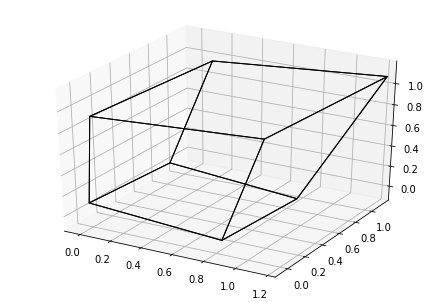

In [ ]:
nh=nonsymmetric_hexahedra()

f0=np.array([nh.vertices[i].J for i in [0,1,2,3]])
face0=pyny.Polygon(f0)
f1=np.array([nh.vertices[i].J for i in [2,3,6,7]])
face1=pyny.Polygon(f1)
f2=np.array([nh.vertices[i].J for i in [4,5,6,7]])
face2=pyny.Polygon(f2)
f3=np.array([nh.vertices[i].J for i in [0,1,4,5]])
face3=pyny.Polygon(f3)
f4=np.array([nh.vertices[i].J for i in [1,3,5,7]])
face4=pyny.Polygon(f4)
f5=np.array([nh.vertices[i].J for i in [0,2,4,6]])
face5=pyny.Polygon(f5)

hexahedra=pyny.Polyhedron([face0,face1,face2,face3,face4,face5])
hexahedra.plot(color='t')

In [ ]:
hexahedra.get_area()
hexahedra.get_domain()

array([[-0.07793023, -0.09615378, -0.02133692],
       [ 1.21794302,  1.17221277,  1.08967428]])